# Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

> 🛠 **Practice:** Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

## 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.

In [1]:
# Download zip file of 10_food_classes images
# (Skip, load the data locally)

Now let's check out all of the different directories and sub-directories in the `10_food_classes` file.

In [2]:
import os

food_classes_dir = "data/image_data/food_classes"

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(food_classes_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/image_data/food_classes'.
There are 10 directories and 0 images in 'data/image_data/food_classes/test'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/chicken_curry'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/chicken_wings'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/fried_rice'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/hamburger'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/ice_cream'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/pizza'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/ramen'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/steak'.
There are 0 directories and 250 images in 'data

Looking good!

We'll now setup the training and test directory paths.

In [3]:
train_dir = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

And get the class names from the subdirectories.

In [4]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


How about we visualize an image from the training set?

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off") # Turn off axis
    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 382, 3)


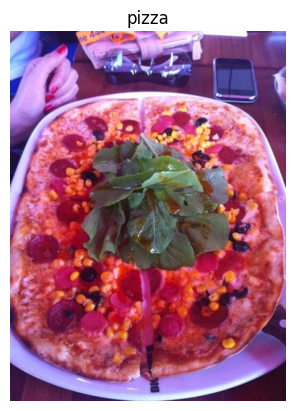

In [6]:
# View a random image from the training dataset
import random
img = view_random_image(
    target_dir=train_dir,
    target_class=random.choice(class_names) # get a random class name
)

## 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # changed to categorical
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

2024-12-22 09:29:48.232832: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 09:29:54.035163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 09:29:56.035326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 09:29:56.583915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 09:30:00.534743: I tensorflow/core/platform/cpu_feature_guar

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


As with binary classifcation, we've creator image generators. The main change this time is that we've changed the `class_mode` parameter to `'categorical'` because we're dealing with 10 classes of food images.

Everything else like rescaling the images, creating the batch size and target image size stay the same.

> 🤔 **Question:** Why is the image size 224x224? This could actually be any size we wanted, however, 224x224 is a very common size for preprocessing images to. Depending on your problem you might want to use larger or smaller images.

## 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734831064.147026    2163 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734831068.878522    2163 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734831068.878596    2163 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:173483

## 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [9]:
# Fit the model
history_9 = model_9.fit(
    train_data, # now 10 different classes 
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data,
    validation_steps=validation_steps
)

Epoch 1/5


/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734831078.665842    3856 service.cc:146] XLA service 0x7f87c0004200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734831078.665904    3856 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-22 09:31:19.087043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-22 09:31:19.970351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531

  1/234 ━━━━━━━━━━━━━━━━━━━━ 1:07:59 18s/step - accuracy: 0.0625 - loss: 2.3061

I0000 00:00:1734831091.731350    3856 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 ━━━━━━━━━━━━━━━━━━━━ 153s 580ms/step - accuracy: 0.1715 - loss: 2.2255 - val_accuracy: 0.2925 - val_loss: 1.9710
Epoch 2/5
  1/234 ━━━━━━━━━━━━━━━━━━━━ 44s 189ms/step - accuracy: 0.1562 - loss: 2.0437

2024-12-22 09:33:47.105559: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-22 09:33:47.105705: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-22 09:33:47.105741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:33:47.105830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1562 - loss: 2.0437 - val_accuracy: 0.5000 - val_loss: 2.0662
Epoch 3/5


2024-12-22 09:33:47.598814: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-22 09:33:47.598877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:33:47.598911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 59s 245ms/step - accuracy: 0.3715 - loss: 1.8476 - val_accuracy: 0.3173 - val_loss: 1.9600
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.3438 - loss: 1.7317 - val_accuracy: 0.0000e+00 - val_loss: 2.3166
Epoch 5/5


2024-12-22 09:34:46.318310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:34:46.318403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324
2024-12-22 09:34:46.327168: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-22 09:34:46.327224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:34:46.327256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 59s 245ms/step - accuracy: 0.5315 - loss: 1.3819 - val_accuracy: 0.2857 - val_loss: 2.1459


Why do you think each epoch takes longer than when working with only two classes of images?

It's because we're now dealing with more images than we were before. We've got 10 classes with 750 training images and 250 validation images each totalling 10,000 images. Where as when we had two classes, we had 1500 training images and 500 validation images, totalling 2000.

The intuitive reasoning here is the more data you have, the longer a model will take to find patterns.

## 5. Evaluate the model

In [10]:
# Evaluate on the test data
model_9.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.2853 - loss: 2.1335


[2.1459577083587646, 0.2856000065803528]

In [11]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

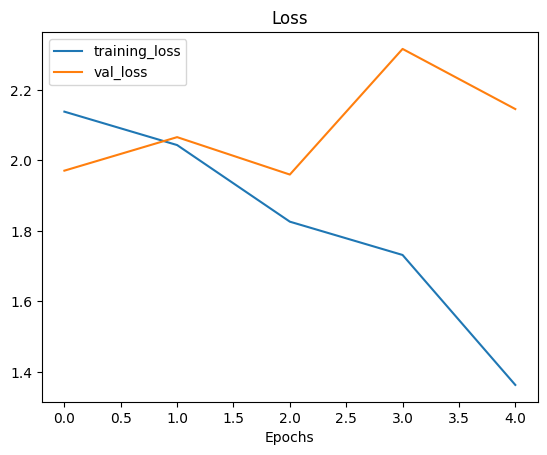

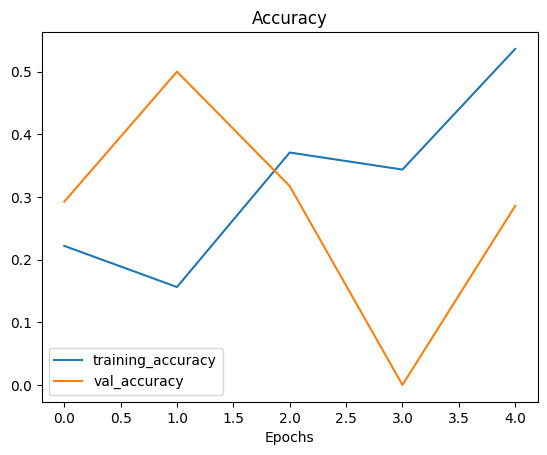

In [12]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from 1st CNN notebook)
plot_loss_curves(history_9)

Woah, that's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

## 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

In [13]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_10 = model_10.fit(
    train_data,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data,
    validation_steps=validation_steps
)

Epoch 1/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 59s 239ms/step - accuracy: 0.1842 - loss: 2.2612 - val_accuracy: 0.3009 - val_loss: 1.9716
Epoch 2/5
  1/234 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - accuracy: 0.3125 - loss: 1.9819

2024-12-22 09:37:00.365901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:37:00.366107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.9819 - val_accuracy: 0.5000 - val_loss: 2.4098
Epoch 3/5


2024-12-22 09:37:00.642812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:37:00.642894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 357ms/step - accuracy: 0.3430 - loss: 1.8897 - val_accuracy: 0.3197 - val_loss: 1.9155
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.3438 - loss: 1.8406 - val_accuracy: 0.0000e+00 - val_loss: 2.0615
Epoch 5/5


2024-12-22 09:38:25.477852: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-22 09:38:25.478001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:38:25.478100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 91s 376ms/step - accuracy: 0.4547 - loss: 1.6423 - val_accuracy: 0.3522 - val_loss: 1.8939


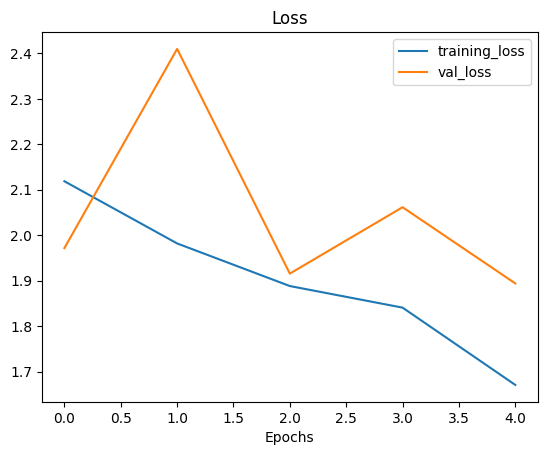

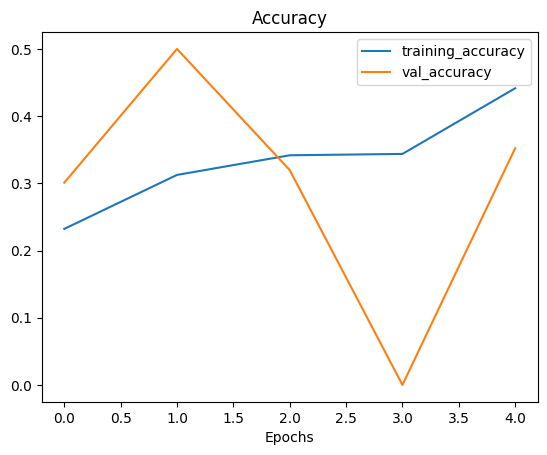

In [14]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

Hmm... even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [15]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20, # note: this is an int not a float
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.


In [16]:

train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model as before (`model_10`).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

> 🔑 **Note:** One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [17]:
# Clone model_10 to model_11 (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile model_11
model_11.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model_11 with augmented data
history_11 = model_11.fit(
    train_data_augmented,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data,
    validation_steps=validation_steps
)

Epoch 1/5


/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 88s 363ms/step - accuracy: 0.1796 - loss: 2.2400 - val_accuracy: 0.2740 - val_loss: 2.0009
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.2188 - loss: 2.1618 - val_accuracy: 0.2500 - val_loss: 1.9533
Epoch 3/5


2024-12-22 09:41:27.851914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:41:27.852004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-12-22 09:41:28.026256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:41:28.026350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 352ms/step - accuracy: 0.2578 - loss: 2.0682 - val_accuracy: 0.3313 - val_loss: 1.8920
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.2188 - loss: 2.0821 - val_accuracy: 0.5000 - val_loss: 2.2433
Epoch 5/5


2024-12-22 09:42:52.774681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:42:52.774894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324
2024-12-22 09:42:52.788526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15588547540597586071
2024-12-22 09:42:52.788687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7686144527300085324


234/234 ━━━━━━━━━━━━━━━━━━━━ 86s 359ms/step - accuracy: 0.2931 - loss: 2.0148 - val_accuracy: 0.3786 - val_loss: 1.8355


You can see it each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

> **Note:** One way to improve this time taken is to use augmentation layers directly as part of the model. For example, with [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip). You can also speed up data loading with the newer [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) image loading API (we cover this later in the course).

How do our model's training curves look?

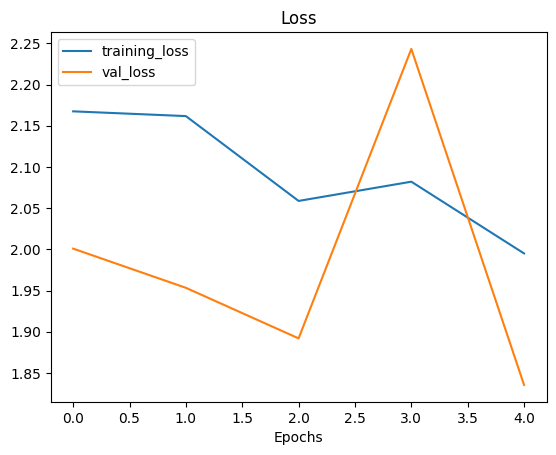

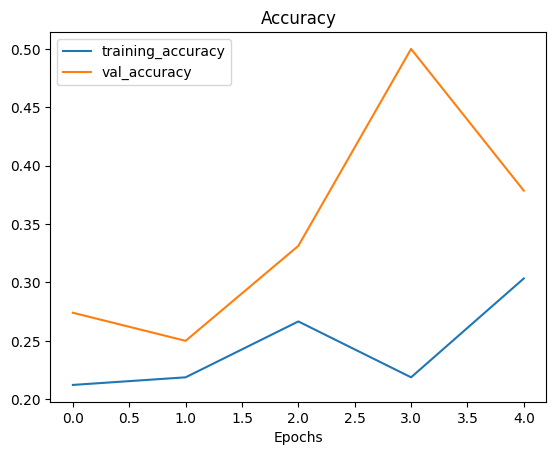

In [18]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

Woah! That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.

## 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

## 8. Making a prediction with our trained model

What good is a model if you can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

In [19]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Beautiful, now let's get some of our custom images. (using local images)

Okay, we've got some custom images to try, let's use the `pred_and_plot` function to make a prediction with `model_11` on one of the images and plot it.

In [20]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    img = img / 255.
    return img

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class and probability
    pred_class = class_names[int(tf.round(pred)[0][0])]
    pred_prob = tf.reduce_max(pred).numpy() * 100  # Get the highest probability and convert to percentage

    # Plot the image and predicted class with probability
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class} ({pred_prob:.2f}%)")
    plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


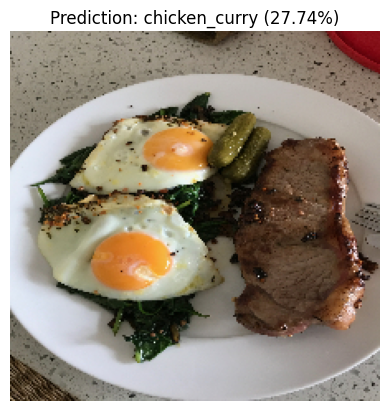

In [23]:
# Make some predictions using model_11
steak_image = food_classes_dir + "/03-steak.jpeg"

pred_and_plot(model=model_11, 
              filename=steak_image, 
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


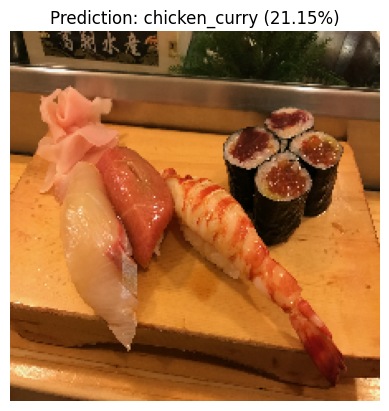

In [24]:
sushi_image = food_classes_dir + "/03-sushi.jpeg"

pred_and_plot(model=model_11, 
              filename=sushi_image, 
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


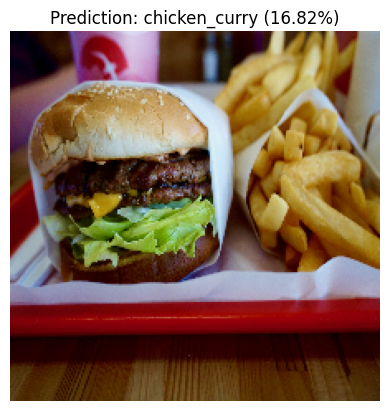

In [25]:
hamburger_image = food_classes_dir + "/03-hamburger.jpeg"

pred_and_plot(model=model_11, 
              filename=hamburger_image, 
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


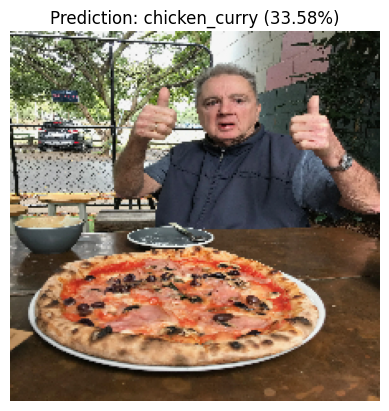

In [26]:
pizza_image = food_classes_dir + "/03-pizza.jpeg"

pred_and_plot(model=model_11, 
              filename=pizza_image, 
              class_names=class_names)

`chicken_curry` again? There must be something wrong...

I think it might have to do with our `pred_and_plot` function.

Let's makes a prediction without using the function and see where it might be going wrong.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


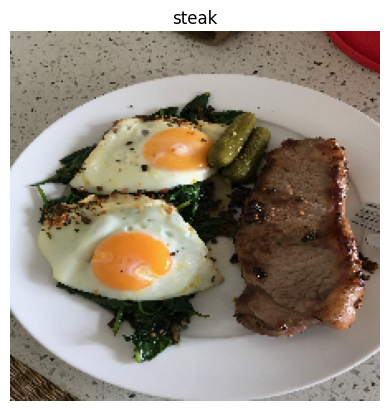

In [28]:
# Load in and preprocess our custom image
img = load_and_prep_image(steak_image)

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our `pred_and_plot` function.

And I think I know what it is.

The `pred_and_plot` function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the `predict` function.

In [29]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[0.04239212, 0.03658016, 0.03787821, 0.26091185, 0.08313756,
        0.0196305 , 0.04307114, 0.10597696, 0.2774377 , 0.09298381]],
      dtype=float32)

Since our model has a `'softmax'` activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) and then use that to index our `class_names` list to output the predicted class.

In [30]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than `chicken_curry` every time).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


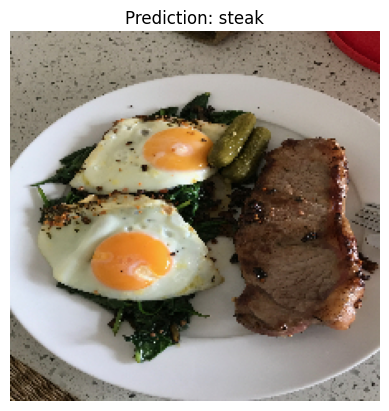

In [35]:
pred_and_plot(model=model_11, 
              filename=steak_image, 
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


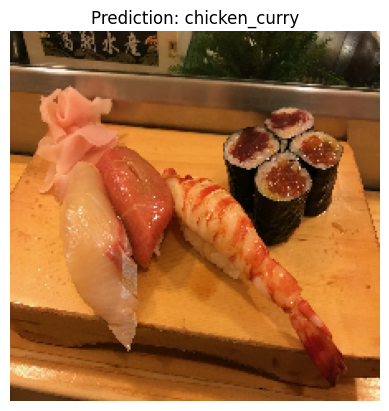

In [36]:
pred_and_plot(model=model_11,
              filename=sushi_image,
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


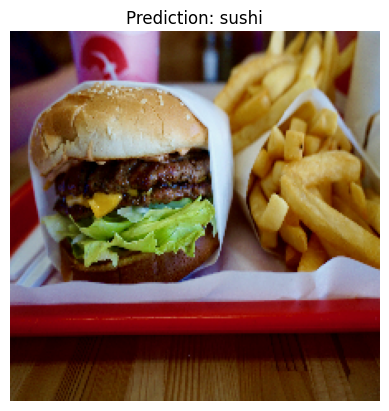

In [37]:
pred_and_plot(model=model_11,
              filename=hamburger_image,
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


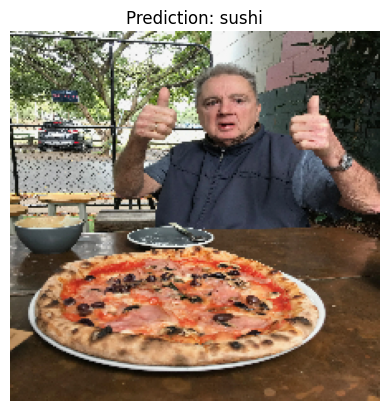

In [38]:
pred_and_plot(model=model_11, 
              filename=pizza_image, 
              class_names=class_names)

Our model's predictions aren't very good, this is because it's only performing at ~35% accuracy on the test dataset.

We'll see how to improve this later on (spolier: [transfer learning](https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/) is going to step things up a notch).